In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

#rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [3]:
columns = ['x-axis', 'y-axis','z-axis','xg-axis', 'yg-axis','zg-axis','activity']
df1 = pd.read_csv('Sumit_task2.csv', header = None, names = columns)
df2 = pd.read_csv('Sumit_task2_1.csv', header = None, names = columns)
df3 = pd.read_csv('Sumit_walking.csv', header = None, names = columns)
df4 = pd.read_csv('Sumit_sitting.csv', header = None, names = columns)
#df5 = pd.read_csv('dataset/new_action.csv', header = None, names = columns)
df = pd.concat([df1, df2, df3,df4], ignore_index= True)
#df  = df.iloc[1:]
df = df.dropna()

In [4]:
df.head()

,x-axis,y-axis,z-axis,xg-axis,yg-axis,zg-axis,activity
0,-0.765,0.075,0.660,-7.195,-2.561,2.927,1
1,-0.775,0.068,0.656,-6.707,-1.707,2.744,1
2,-0.776,0.055,0.662,-6.707,1.098,2.073,1
3,-0.773,0.057,0.669,-6.037,2.927,0.976,1
4,-0.784,0.061,0.668,-5.183,0.610,0.122,1


In [5]:
df.shape

(27112, 7)

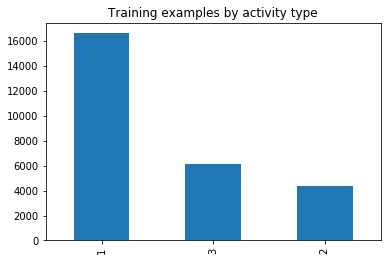

In [6]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');


In [7]:
N_TIME_STEPS = 200
N_FEATURES = 6
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    xsg = df['xg-axis'].values[i: i + N_TIME_STEPS]
    ysg = df['yg-axis'].values[i: i + N_TIME_STEPS]
    zsg = df['zg-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    #print label
    segments.append([xs, ys, zs, xsg, ysg, zsg])
    labels.append(label)
    #print labels

In [8]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [9]:
reshaped_segments.shape

(1346, 200, 6)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [11]:
X_train.shape

(1076, 200, 6)

In [12]:
X_test.shape

(270, 200, 6)

In [13]:
N_CLASSES = 3
N_HIDDEN_UNITS = 64

In [14]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [15]:

#tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

In [16]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [18]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [19]:
N_EPOCHS = 20
BATCH_SIZE = 128

In [ ]:
saver = tf.train.Saver()

history = dict(train_loss=[], 
                     train_acc=[], 
                     test_loss=[], 
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    #if i != 1 and i % 10 != 0:
        #continue

    print("epoch " + str(i) + ":  "+ "test accuracy:" + " " + str(acc_test) + " " + "loss:" + str(loss_test))
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

#print()
print("final results: accuracy:   " + str(acc_final) + "\t" +  "loss:  " +str(loss_final))

epoch 1:  test accuracy: 0.837037 loss:1.1229072
epoch 2:  test accuracy: 0.9222222 loss:0.96819085
epoch 3:  test accuracy: 0.9444444 loss:0.87812316
epoch 4:  test accuracy: 0.95185184 loss:0.8330026
epoch 5:  test accuracy: 0.95555556 loss:0.8366672
epoch 6:  test accuracy: 0.94814813 loss:0.79871273
epoch 7:  test accuracy: 0.9592593 loss:0.80443245
epoch 8:  test accuracy: 0.95185184 loss:0.8214911
epoch 9:  test accuracy: 0.9592593 loss:0.8058473
epoch 10:  test accuracy: 0.962963 loss:0.7616511
epoch 11:  test accuracy: 0.97037035 loss:0.7641926
epoch 12:  test accuracy: 0.97037035 loss:0.75350434
epoch 13:  test accuracy: 0.97037035 loss:0.7286054


In [20]:
pickle.dump(predictions, open("predictions_task2.p", "wb"))
pickle.dump(history, open("history_task2.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/activity_task2.pbtxt')  
saver.save(sess, save_path = "./checkpoint/activity_task2.ckpt")
sess.close()

In [21]:
history = pickle.load(open("history_task2.p", "rb"))
predictions = pickle.load(open("predictions_task2.p", "rb"))

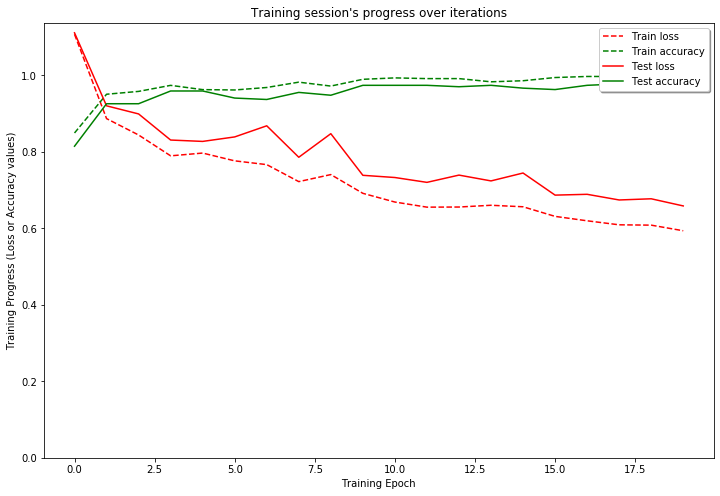

In [22]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [23]:
#activity
LABELS = ['task1','walking','sitting']

In [24]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [25]:
#max_test = np.argmax(y_test, axis=1)
#ls = list(max_test)
#ls


In [26]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)

max_test1 = max_test.tolist()
print (max_test1)
print (type(max_test1))
max_predictions1 = max_predictions.tolist()
print(max_predictions1)

confusion_matrix(max_test1, max_predictions1)


[1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 1, 1, 0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0]
<class 'list'>
[1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,

array([[169,   0,   5],
       [  0,  44,   0],
       [  2,   0,  50]])

In [ ]:
max_test = np.argmax(y_test, axis=1)
M